Mean Accuracy: 0.9973
Mean Precision: 0.9973
Mean Recall: 0.9973
Mean F1 Score: 0.9973
Training Time: 8.70 seconds

Test Metrics:
Accuracy: 0.9983
Precision: 0.9983
Recall: 0.9983
F1 Score: 0.9983


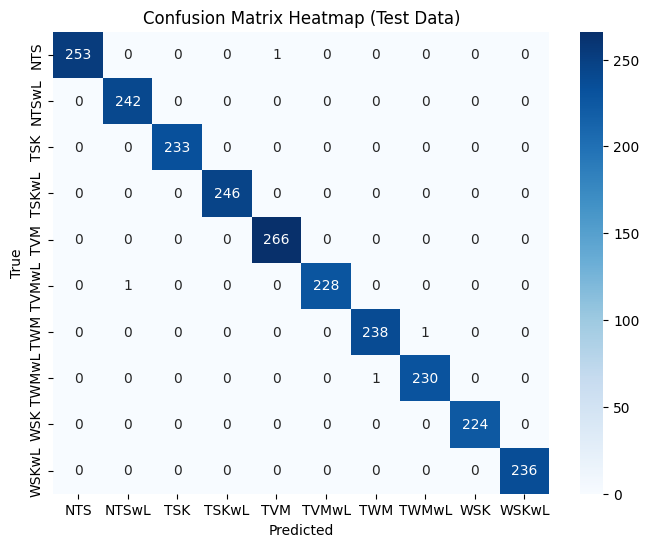

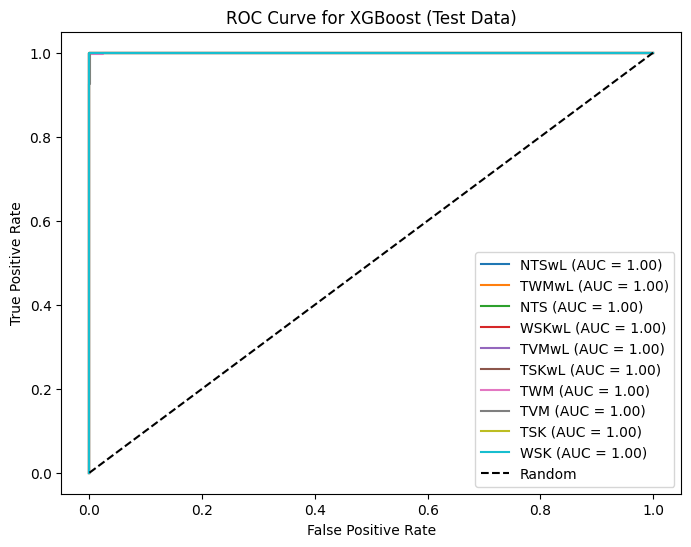

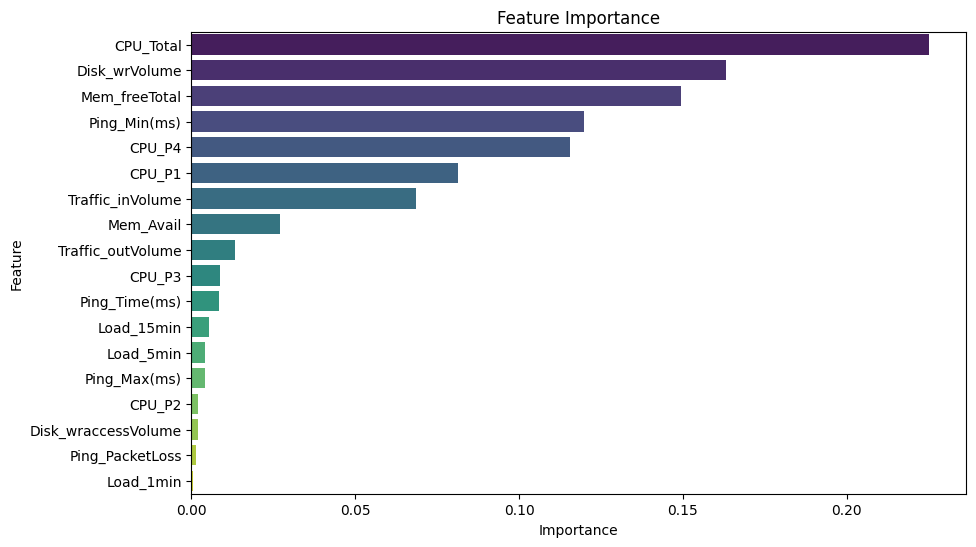


(evince:1608): dconf-WARNING **: 03:18:10.526: failed to commit changes to dconf: Failed to execute child process “dbus-launch” (No such file or directory)


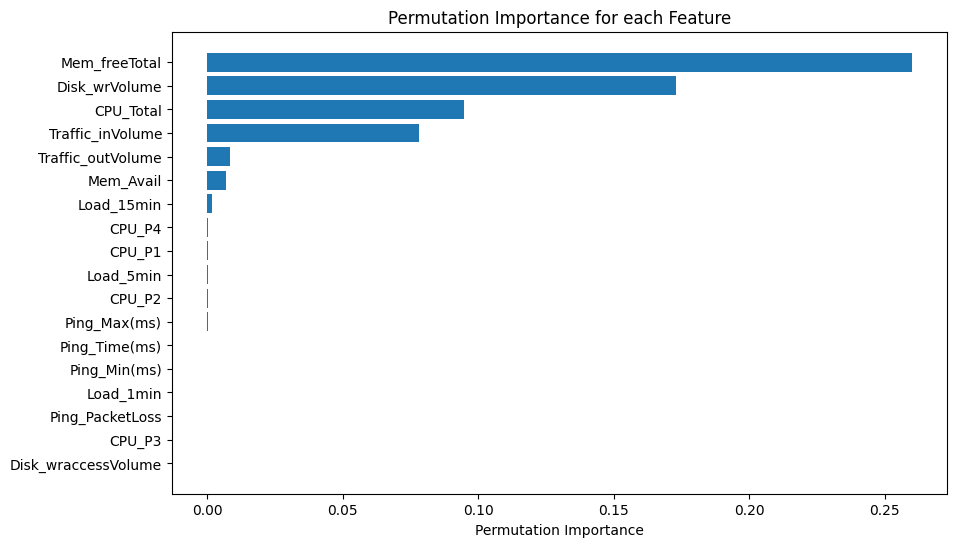

In [1]:
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import to_graphviz
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import subprocess
import time


# Load training data
train_file_path = '/home/kali/project/c9-python-getting-started/train_18f.csv'  # Update with the path to your training data
train_data = pd.read_csv(train_file_path)

# Load testing data
test_file_path = '/home/kali/project/c9-python-getting-started/test_18f.csv'  # Update with the path to your test data
test_data = pd.read_csv(test_file_path)


# Labels to drop from 'Class' column [sample]
# labels_to_drop = [NTS','TVM', 'TWM', 'WSK', 'TSK', 'NTSwL','TVMwL','TWMwL','WSKwL','TSKwL']  # Add the labels you want to drop
# Without Labels to drop 
labels_to_drop = [] 
# Binary classification test[NTS-Sniff, NTSwL-Sniff with Load]
# labels_to_drop = ['NTS','TVM','TWM', 'WSK', 'TSK']  # Add the labels you want to drop


# Drop rows with specified labels from 'Class' column
train_data = train_data[~train_data['Class'].isin(labels_to_drop)]
test_data = test_data[~test_data['Class'].isin(labels_to_drop)]

# Reset index if needed
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


# Drop List for 18 features
features_to_drop = ['Class']
# Drop List for 7 features
# features_to_drop = ['Class', 'CPU_P1', 'CPU_P2', 'CPU_P3', 'CPU_P4', 'Load_1min', 'Load_5min', 'Load_15min', 'Ping_Time(ms)', 'Ping_Min(ms)', 'Ping_Max(ms)', 'Ping_PacketLoss']
# Drop List for only ping feature
# features_to_drop = ['Class', 'CPU_Total', 'CPU_P1', 'CPU_P2', 'CPU_P3', 'CPU_P4', 'Disk_wrVolume', 'Disk_wraccessVolume', 'Load_1min', 'Load_5min', 'Load_15min', 'Mem_Avail', 'Mem_freeTotal', 'Traffic_inVolume', 'Traffic_outVolume']

# Assume your target variable is named 'Class' and features are other columns
X_train = train_data.drop(features_to_drop, axis=1)
y_train = train_data['Class']
X_test = test_data.drop(features_to_drop, axis=1)
y_test = test_data['Class']

# If the 'Class' column contains categorical labels, encode them using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize the XGBoost model
xgb_model = XGBClassifier(max_depth=7, random_state=42)


# Perform 10-fold cross-validation on the training data
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Record the start time
start_time = time.time()

for train_index, val_index in stratified_kfold.split(X_train, y_train_encoded):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Train the model on the training fold
    xgb_model.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_val_pred = xgb_model.predict(X_val_fold)

    # Evaluate the model on the validation fold
    accuracy_list.append(accuracy_score(y_val_fold, y_val_pred))
    precision_list.append(precision_score(y_val_fold, y_val_pred, average='weighted'))
    recall_list.append(recall_score(y_val_fold, y_val_pred, average='weighted'))
    f1_list.append(f1_score(y_val_fold, y_val_pred, average='weighted'))

# Record the end time
end_time = time.time()

# Calculate mean metrics over all folds
mean_accuracy = sum(accuracy_list) / len(accuracy_list)
mean_precision = sum(precision_list) / len(precision_list)
mean_recall = sum(recall_list) / len(recall_list)
mean_f1 = sum(f1_list) / len(f1_list)

# Print mean metrics
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Train the model on the entire training data
xgb_model.fit(X_train, y_train_encoded)

# Predict on the test data
y_test_pred = xgb_model.predict(X_test)

# Evaluate the model on the test data
accuracy_test = accuracy_score(y_test_encoded, y_test_pred)
precision_test = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall_test = recall_score(y_test_encoded, y_test_pred, average='weighted')
f1_test = f1_score(y_test_encoded, y_test_pred, average='weighted')

# Print test metrics
print("\nTest Metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")

# Plot Confusion Matrix Heatmap for the test data
conf_matrix_test = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap (Test Data)')
plt.show()

# Plot ROC Curve and Calculate AUC for the test data
n_classes = len(label_encoder.classes_)
y_test_proba = xgb_model.predict_proba(X_test)

# One-hot encode the true labels
y_test_one_hot = pd.get_dummies(y_test_encoded, columns=label_encoder.classes_)

# Assuming y_test contains the true class labels
unique_classes = y_test.unique()

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_one_hot.iloc[:, i], y_test_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{unique_classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost (Test Data)')
plt.legend(loc='lower right')
plt.show()

# Plot one of the trees from the XGBoost model using Graphviz
# Here, we plot the first tree in the model
dot_data = to_graphviz(xgb_model, num_trees=0, rankdir='UT', yes_color='#0000FF', no_color='#FF0000')
dot_data.render("xgb_tree", format="pdf", cleanup=True)
dot_data.view("xgb_tree")


# Display the feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_model.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance_df, palette='viridis', legend=False)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Permutation Importance
result = permutation_importance(xgb_model, X_test, y_test_encoded, n_repeats=30, random_state=42)
sorted_idx = result.importances_mean.argsort()

# Plot permutation importance
plt.figure(figsize=(10, 6))
plt.barh(range(X_test.shape[1]), result.importances_mean[sorted_idx])
plt.yticks(range(X_test.shape[1]), X_test.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance for each Feature')
plt.show()